<a href="https://colab.research.google.com/github/MegatronRobot/FastAI_Practical_DL_for_coders_Coursefiles/blob/main/Getting_Started/is_it_bird_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00


In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [6]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'http://hdqwalls.com/download/1/colorful-parrot-bird.jpg'

and then download a URL and take a look at it:

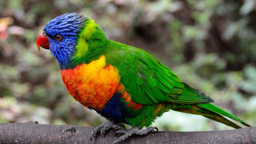

In [7]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


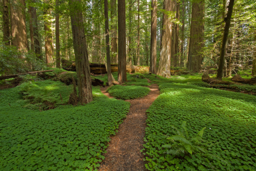

In [8]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [9]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


# Step 2: Train our model

Some photos might now download correctly which could cause our model training to fail, so we will remove them:

In [10]:
failed = verify_images(get_image_files(path)) # get_image_files is a function which returns all image files from the path
failed.map(Path.unlink)
len(failed)

3

To train a model, we'll need `DataLoaders`, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a `DataBlock`, and view sample images from it:

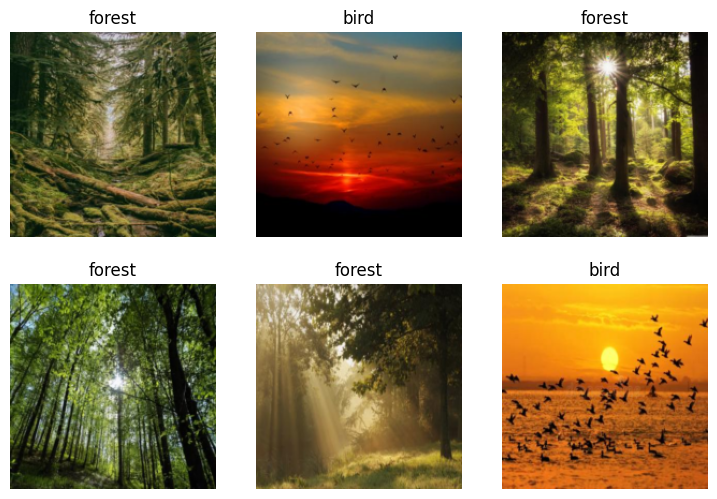

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # this means that Image is in our input and Category(one or more than one values) is our output
    get_items=get_image_files, # this is a function for getting image files as mentioned in the above cell
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # reserving some data for validation set, here is is 20% of original data set
    # splitter is very critical that fastai won't let you train the model without it
    # it randomly set aside some data on seed=42
    get_y=parent_label, # basically returns name of parent folder where the images are saved
    item_tfms=[Resize(192, method='squish')] # all ComputerVision architecture needs images of same size
    # basically in above, resize all images to 192x192, and there are 2 ways of resizing, one is 'squish', just dec. size or 'crop' out the center part of the image
).dataloaders(path, bs=32)
# data loaders are actually things that let pytorch iterate through a batch/minibatch of data at a single instance of time
# it is because of GPU

# showing a batch of the data
dls.show_batch(max_n=6)

`fine_tune` comes with fast ai lib, it already fine tunes models/adjusts parameters pertaining to our data set using best practices.

In [12]:
# a learner is something that combines a neural network model with the data that we will use to train it with
# here our data is dls and actual neural network model is resnet18 that you wanna pass in
learn = vision_learner(dls, resnet18, metrics=error_rate)
# resnet18 is pre trained model that is already trained over 1 million images and over 1000 categories, that's why we are able to train this model really fast
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.822662,0.061135,0.000000,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.213531,0.039005,0.030303,00:29
1,0.134925,0.006239,0.000000,00:30
2,0.093010,0.004507,0.000000,00:30


# Step-3:- Use our model

Let's see what our model thinks about that bird we downloaded at the start:

In [13]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))  # it returns, is_bird_or_not(as a string), is_bird_or_not(as integer), probabilty that it is not bird or bird
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999
